In [18]:
import pandas as pd
import numpy as np

In [19]:
import pandas as pd

train = pd.read_csv("data/raw/rossmann-store-sales/train.csv")
test = pd.read_csv("data/raw/rossmann-store-sales/test.csv")
store = pd.read_csv("data/raw/rossmann-store-sales/store.csv")

/var/folders/qm/tvjk1s9d49d1c9kmlpl2zn900000gn/T/ipykernel_68309/2524423779.py:3: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("data/raw/rossmann-store-sales/train.csv")


In [20]:
# Merge on Store ID
df = train.merge(store, how="left", on="Store")

In [21]:
# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'], format="%Y-%m-%d")

In [22]:
# Extract date features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week.astype(int)
df['DayOfWeek_Name'] = df['Date'].dt.day_name()

In [23]:
# Handle missing values
df['PromoInterval'].fillna("None", inplace=True)
df['Promo2SinceYear'].fillna(0, inplace=True)
df['Promo2SinceWeek'].fillna(0, inplace=True)
df['CompetitionOpenSinceYear'].fillna(0, inplace=True)
df['CompetitionOpenSinceMonth'].fillna(0, inplace=True)
df['CompetitionDistance'].fillna(df['CompetitionDistance'].median(), inplace=True)

In [24]:
# Fix dtype issues (e.g. StateHoliday sometimes numeric)
df['StateHoliday'] = df['StateHoliday'].astype(str)

In [25]:
# Optional: Cap extreme outliers in Sales and Customers
sales_cap = df['Sales'].quantile(0.99)
cust_cap = df['Customers'].quantile(0.99)
df['Sales'] = np.where(df['Sales'] > sales_cap, sales_cap, df['Sales'])
df['Customers'] = np.where(df['Customers'] > cust_cap, cust_cap, df['Customers'])

In [26]:
# Encode categorical variables
cat_cols = ['StateHoliday', 'StoreType', 'Assortment', 'PromoInterval', 'DayOfWeek_Name']
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

In [27]:
# Save cleaned dataset
df.to_csv("data/cleaned/rossmann_cleaned.csv", index=False)

print("✅ Cleaned dataset saved to data/cleaned/rossmann_cleaned.csv")
print(f"Shape: {df.shape}")

✅ Cleaned dataset saved to data/cleaned/rossmann_cleaned.csv
Shape: (1017209, 34)


**EDA**

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
# Load cleaned dataset
df = pd.read_csv("data/cleaned/rossmann_cleaned.csv")

In [30]:
# Make plots prettier
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

In [31]:
# Ensure Date is datetime
df['Date'] = pd.to_datetime(df['Date'])

In [32]:
# Group for time-series analysis
daily_sales_type = df.groupby(['Date', 'StoreType_b', 'StoreType_c', 'StoreType_d'])['Sales'].mean().reset_index()

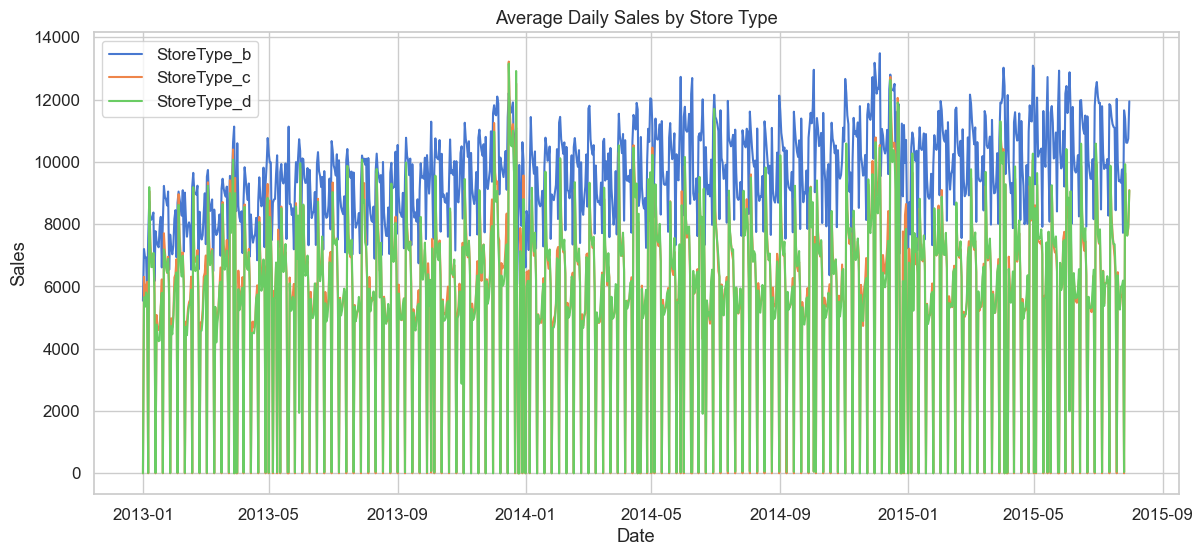

In [33]:
# --- Sales trends over time by store type ---
plt.figure(figsize=(14,6))
for store_type_col in ['StoreType_b', 'StoreType_c', 'StoreType_d']:
    store_type_sales = df[df[store_type_col] == 1].groupby('Date')['Sales'].mean()
    plt.plot(store_type_sales.index, store_type_sales.values, label=store_type_col)
plt.title("Average Daily Sales by Store Type")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

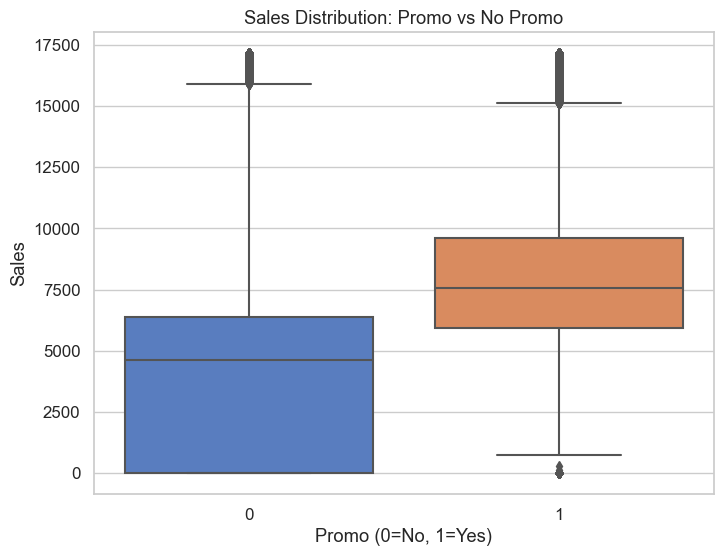

In [34]:
# --- Boxplot: Promo vs Non-Promo ---
plt.figure(figsize=(8,6))
sns.boxplot(data=df, x='Promo', y='Sales')
plt.title("Sales Distribution: Promo vs No Promo")
plt.xlabel("Promo (0=No, 1=Yes)")
plt.ylabel("Sales")
plt.show()

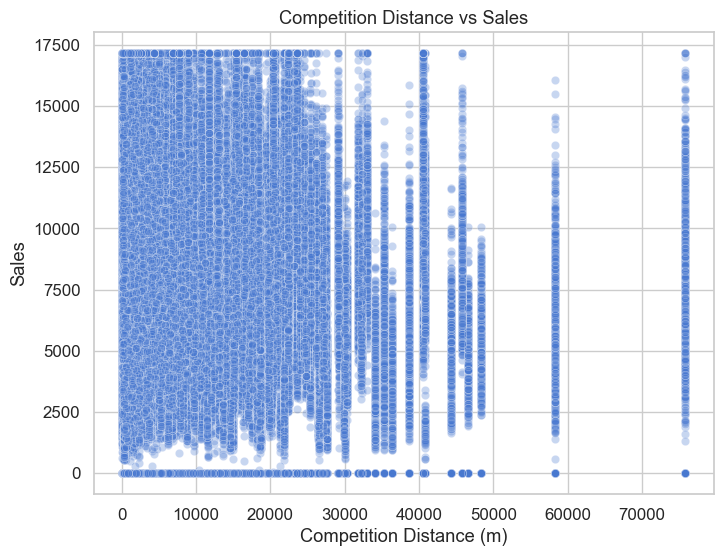

In [35]:
# --- Effect of Competition Distance ---
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='CompetitionDistance', y='Sales', alpha=0.3)
plt.title("Competition Distance vs Sales")
plt.xlabel("Competition Distance (m)")
plt.ylabel("Sales")
plt.show()

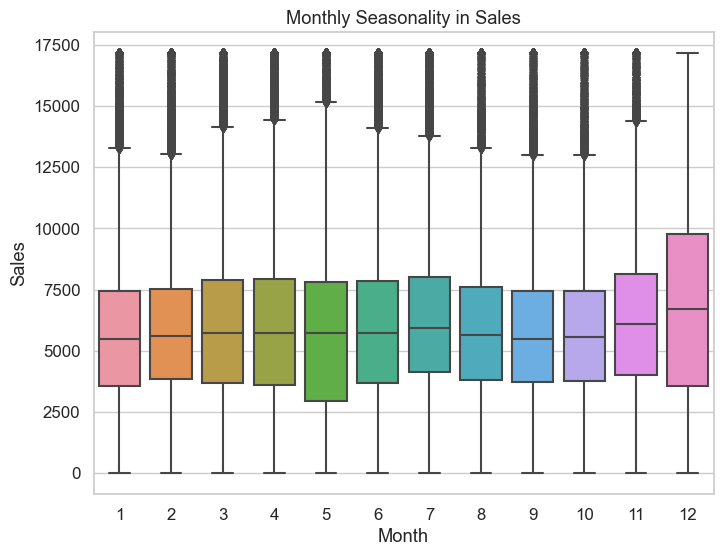

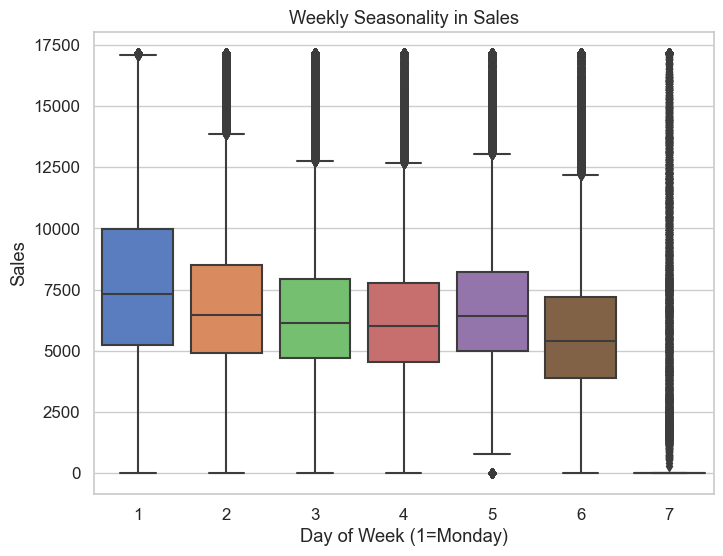

In [36]:
# --- Seasonality patterns ---
# Monthly seasonality
plt.figure(figsize=(8,6))
sns.boxplot(data=df, x='Month', y='Sales')
plt.title("Monthly Seasonality in Sales")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.show()

# Weekly pattern
plt.figure(figsize=(8,6))
sns.boxplot(data=df, x='DayOfWeek', y='Sales')
plt.title("Weekly Seasonality in Sales")
plt.xlabel("Day of Week (1=Monday)")
plt.ylabel("Sales")
plt.show()

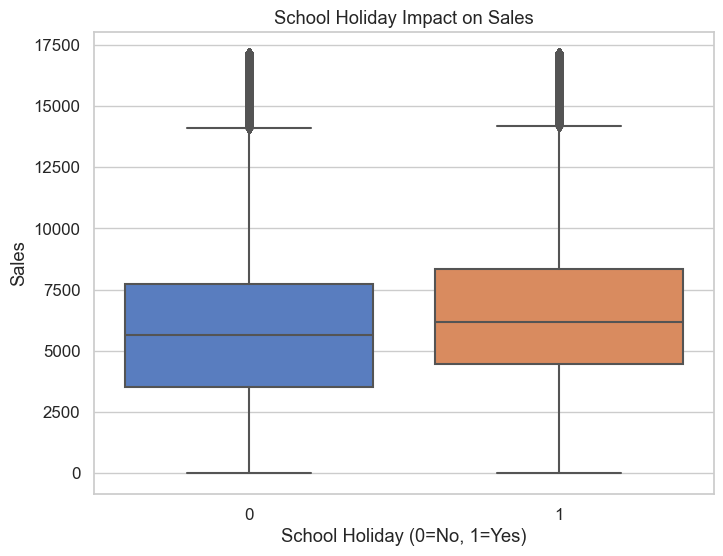

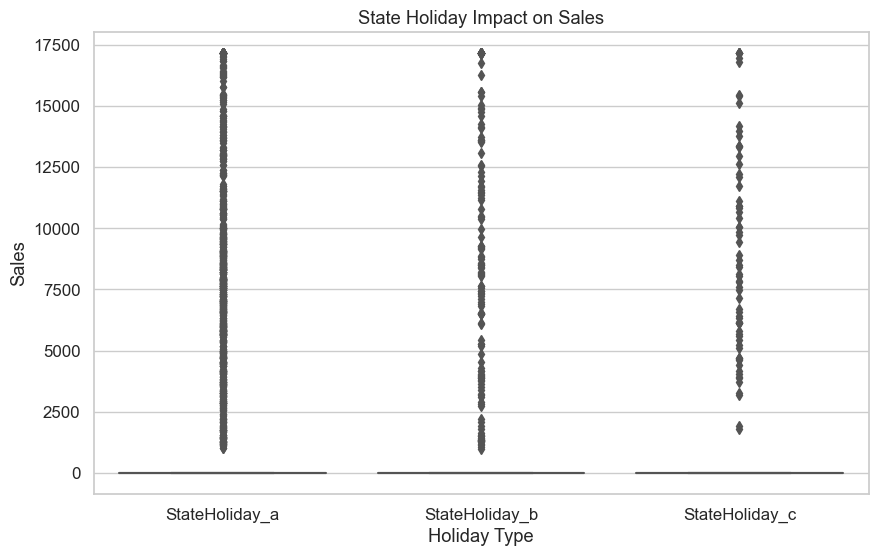

In [38]:
# --- School vs State Holidays ---
plt.figure(figsize=(8,6))
sns.boxplot(data=df, x='SchoolHoliday', y='Sales')
plt.title("School Holiday Impact on Sales")
plt.xlabel("School Holiday (0=No, 1=Yes)")
plt.ylabel("Sales")
plt.show()

# StateHoliday impact
state_cols = [col for col in df.columns if col.startswith('StateHoliday_')]
holiday_df = df.melt(id_vars=['Sales'], value_vars=state_cols, var_name='StateHoliday', value_name='Flag')
holiday_df = holiday_df[holiday_df['Flag'] == 1]
plt.figure(figsize=(10,6))
sns.boxplot(data=holiday_df, x='StateHoliday', y='Sales')
plt.title("State Holiday Impact on Sales")
plt.xlabel("Holiday Type")
plt.ylabel("Sales")
plt.show()